In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
from glob import glob

from skimage.transform import rotate
from skimage.util import montage 

In [2]:
pwd

'/root/project/code/kits'

In [100]:
number = np.random.randint(300)
print(number)
if number < 100:
    number = f'0{str(number)}'
    print(number)
    
ct_path = f'../../kits/kits21/kits21/data/case_00{number}/imaging.nii.gz'
k1_path = f'../../kits/kits21/kits21/data/case_00{number}/segmentations/kidney_instance-1_annotation-1.nii.gz'
k2_path = f'../../kits/kits21/kits21/data/case_00{number}/segmentations/kidney_instance-2_annotation-1.nii.gz'
tm_path = f'../../kits/kits21/kits21/data/case_00{number}/segmentations/tumor_instance-1_annotation-1.nii.gz'
and_path = f'../../kits/kits21/kits21/data/case_00{number}/aggregated_AND_seg.nii.gz'
or_path = f'../../kits/kits21/kits21/data/case_00{number}/aggregated_OR_seg.nii.gz'
maj_path = f'../../kits/kits21/kits21/data/case_00{number}/aggregated_MAJ_seg.nii.gz'

ct_ = nib.load(ct_path).get_fdata()
k1_ = nib.load(k1_path).get_fdata()
k2_ = nib.load(k2_path).get_fdata()
tm_ = nib.load(tm_path).get_fdata()
and_ = nib.load(and_path).get_fdata()
or_ = nib.load(or_path).get_fdata()
maj_ = nib.load(maj_path).get_fdata()


ct_.shape

cy = []
for j,i in tqdm(enumerate(and_)):
    if np.unique(i).max() == 3.0:
        cy.append(j)
len(cy)

226


160it [00:01, 146.79it/s]


6

In [101]:
cy

[47, 48, 49, 62, 63, 64]

In [1]:
# moduel import
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import nibabel as nib
import os
from skimage.transform import resize
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
import pickle
from keras.layers import concatenate
from tensorflow.keras.utils import normalize
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2

In [3]:
path = '/root/project/kits//kits21/kits21/data'
n_classes = 4
p = sorted(os.listdir(path))
p.remove('kits.json')


In [13]:
background,kidney,tumor,cyst = [],[],[],[]
for case in tqdm(p):
    seg = f'{path}/{case}/aggregated_AND_seg.nii.gz'
    seg = nib.load(seg).get_fdata()
    for n,i in enumerate(seg):
        if i.max() == 0.0 :
            background.append(f'{case}/{n}')
        elif i.max() == 1.0 :
            kidney.append(f'{case}/{n}')
        elif i.max() == 2.0 :
            tumor.append(f'{case}/{n}')
        elif i.max() == 3.0 :
            cyst.append(f'{case}/{n}')
                          

100%|██████████| 300/300 [05:49<00:00,  1.16s/it]


In [14]:
len(background)

41995

In [15]:
len(kidney)

12903

In [16]:
len(tumor)

7397

In [17]:
len(cyst)

2869

In [20]:
cyst

['case_00002/45',
 'case_00002/46',
 'case_00002/47',
 'case_00002/48',
 'case_00002/49',
 'case_00002/50',
 'case_00002/51',
 'case_00002/52',
 'case_00002/53',
 'case_00002/54',
 'case_00002/55',
 'case_00002/56',
 'case_00002/57',
 'case_00002/58',
 'case_00002/59',
 'case_00002/60',
 'case_00002/61',
 'case_00002/62',
 'case_00002/63',
 'case_00002/64',
 'case_00002/65',
 'case_00002/66',
 'case_00002/67',
 'case_00002/68',
 'case_00002/69',
 'case_00002/70',
 'case_00002/71',
 'case_00002/72',
 'case_00002/73',
 'case_00002/74',
 'case_00002/75',
 'case_00002/76',
 'case_00002/77',
 'case_00002/78',
 'case_00002/79',
 'case_00002/80',
 'case_00002/81',
 'case_00002/82',
 'case_00002/83',
 'case_00002/84',
 'case_00002/85',
 'case_00002/86',
 'case_00002/87',
 'case_00002/88',
 'case_00002/89',
 'case_00002/90',
 'case_00002/91',
 'case_00002/183',
 'case_00002/184',
 'case_00002/185',
 'case_00002/186',
 'case_00002/187',
 'case_00002/188',
 'case_00002/189',
 'case_00002/190',
 '

In [1]:
def transform_to_hu(medical_image, image):
    # medical_image = pydicom.read_file
    # image = medical_image.pixel_array

    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image


def normalize_image(image, center, width):
    # image = transform_to_hu result

    img_min = center - width // 2
    img_max = center + width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [45]:
import nibabel as nib
Test = nib.load('/root/project/kits/kits21/kits21/data/case_00003/imaging.nii.gz').get_fdata()

In [46]:
"""We clipped the image intensity values between -150 HU and 200 HU and rescaled them between 0 and 1.  We used Adam optimizer with a learning rate of 1.10 − 4 on batches of 10 images."""

'We clipped the image intensity values between -150 HU and 200 HU and rescaled them between 0 and 1.  We used Adam optimizer with a learning rate of 1.10 − 4 on batches of 10 images.'

In [47]:
def interval_mapping(image, from_min, from_max, to_min, to_max):
    from_range = from_max - from_min
    to_range = to_max - to_min
    scaled = np.array((image - from_min) / float(from_range), dtype=float)
    return to_min + (scaled * to_range)

In [48]:
import numpy as np
proj = np.clip(Test[100], -150, 200)
proj_inter = interval_mapping(proj, -150, 200, 0, 1)

In [49]:
from matplotlib import pyplot as plt
%matplotlib inline

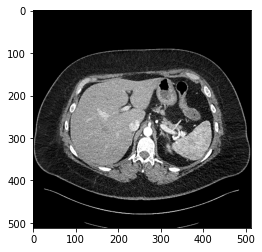

In [50]:
plt.imshow(proj,cmap='gray')

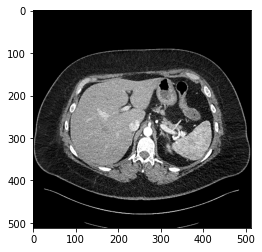

In [51]:
plt.imshow(proj_inter,cmap='gray')

In [52]:
proj_inter.dtype

dtype('<f8')

In [57]:
proj_inter.min()

0.0

In [58]:
proj_inter.max()

1.0

In [59]:
a = proj_inter * 255

In [60]:
a.max()

255.0

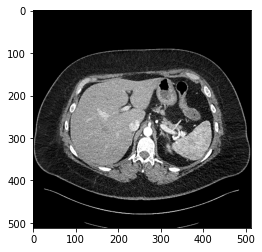

In [62]:
plt.imshow(a,cmap='gray')

In [32]:
Test = nib.load('/root/project/kits/kits21/kits21/data/case_00003/imaging.nii.gz')
isoscale_resolution = Test.header['pixdim'][1:4]

In [33]:
isoscale_resolution

array([1.        , 0.85546875, 0.85546875], dtype=float32)

In [37]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
def interval_mapping(image, from_min, from_max, to_min, to_max):
    from_range = from_max - from_min
    to_range = to_max - to_min
    scaled = np.array((image - from_min) / float(from_range), dtype=float)
    return to_min + (scaled * to_range)
def createMIP_transverse(np_img, slices_num):
    ''' create the mip image from original image, slice_num is the number of slices for maximum intensity projection'''
    img_shape = np.shape(np_img)
    np_mip = np.zeros_like(np_img)
    for i in range(img_shape[2]-slices_num):
        np_mip[:, :, i] = np.amax(np_img[:, :, i:(i + slices_num)], axis=2)
    return np_mip
def do_interpolate(image_data, steps):
    dx, dy, dz = 1., 1., 1.   # step sizes
    x, y, z = [steps[k] * np.arange(image_data.shape[k]) for k in range(len(steps))] 
    f_scan = si.RegularGridInterpolator((x, y, z), image_data, method='linear') 
    new_grid = np.mgrid[0:x[-1]:dx, 0:y[-1]:dy, 0:z[-1]:dz]
    new_grid = np.moveaxis(new_grid, (0, 1, 2, 3), (3, 0, 1, 2)) 
    return f_scan(new_grid)


In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as si
def interval_mapping(image, from_min, from_max, to_min, to_max):
    from_range = from_max - from_min
    to_range = to_max - to_min
    scaled = np.array((image - from_min) / float(from_range), dtype=float)
    return to_min + (scaled * to_range)
def createMIP_transverse(np_img, slices_num):
    ''' create the mip image from original image, slice_num is the number of slices for maximum intensity projection'''
    img_shape = np.shape(np_img)
    np_mip = np.zeros_like(np_img)
    for i in range(img_shape[2]-slices_num):
        np_mip[:, :, i] = np.amax(np_img[:, :, i:(i + slices_num)], axis=2)
    return np_mip
# function to make volume isotropic with voxel size 1x1x1
def do_interpolate(image_data, steps):
    dx, dy, dz = 1., 1., 1.   # step sizes
    x, y, z = [steps[k] * np.arange(image_data.shape[k]) for k in range(len(steps))] 
    f_scan = si.RegularGridInterpolator((x, y, z), image_data, method='linear') 
    new_grid = np.mgrid[0:x[-1]:dx, 0:y[-1]:dy, 0:z[-1]:dz]
    new_grid = np.moveaxis(new_grid, (0, 1, 2, 3), (3, 0, 1, 2)) 
    return f_scan(new_grid)

nrrd_filename = "/root/project/kits/kits21/kits21/data/case_00003/imaging.nii.gz"
CT_volume = nib.load(nrrd_filename)
isoscale_resolution = CT_volume.header['pixdim'][1:4]
image_data = CT_volume.get_fdata()
scandata= do_interpolate(image_data, isoscale_resolution)
x, y, z = np.shape(scandata)

# clip 
proj = np.clip(scandata, -100, 1000)
# convert to 0-1
proj = interval_mapping(proj, -100, 1000, 0, 1)

                
# # MIP
# slices_num = 5
# proj_sh = createMIP_transverse(proj, slices_num)
# slice_i = 10
# filetitle(str(slice_i) + ".png")
# plt.imsave(filetitle, proj_sh[:, :, slice_i], cmap='gray')